In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector, WavesDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'cpu'})
config.set({'lazy': True})

In [8]:
1

1

In [19]:
client = Client()

In [2]:
atoms = bulk('Au', 'diamond', a=5.43, cubic=True)
atoms *= (2, 2, 1)

In [9]:
# number of plane waves in each chunk
plane_wave_chunks = 32

# partioning of the griscan. The scattering matrix will be reduced in similarly partitioned chunks. Should be equal to or greater than the interpolation.
scan_partitions = (3, 3)

# Number of positions per reduction operation (single call to np.tensordot), 
# A large value reduces the number of required iterations in Python, but also increases the total number of FLOPS required
positions_per_reduction = 300

# Maximum number of scattering matrices in memory at any point
max_concurrent_s_matrices = 6

frozen_phonons = FrozenPhonons(atoms, 1, {'Au': .0})

potential = Potential(atoms, 
                      gpts=256,
                      projection='infinite', 
                      slice_thickness=2)

probe = SMatrix(potential, energy=100e3, planewave_cutoff=20, chunks=plane_wave_chunks, interpolation=1)

scan = GridScan()


probe = probe.build(lazy=True)

detectors = AnnularDetector(50, 100, ensemble_mean=True)


measurement = probe.reduce(positions=scan, detectors=detectors)

#probe.grid.match(potential)


# measurement = probe.scan(scan,
#                          detectors,
#                          potential,
#                          scan_partitions=scan_partitions,
#                          positions_per_reduction=positions_per_reduction)

In [7]:
%%time
measurement.compute()

[########################################] | 100% Completed |  1.0s
Wall time: 1.01 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x18ec28161f0>)

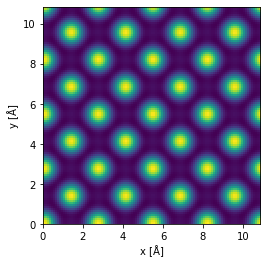

In [44]:
measurement.interpolate(.1).show()